In [22]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd


class ProbabilityVector:
    def __init__(self, probabilities: dict):
        states = probabilities.keys()
        probs  = probabilities.values()
        
        assert len(states) == len(probs)
            #"The probabilities must match the states."
        assert len(states) == len(set(states))
           # "The states must be unique."
        assert abs(sum(probs) - 1.0) < 1e-12
            #"Probabilities must sum up to 1."
        assert len(list(filter(lambda x: 0 <= x <= 1, probs))) == len(probs)
            #"Probabilities must be numbers from [0, 1] interval."
        
        self.states = sorted(probabilities)
        self.values = np.array(list(map(lambda x: 
            probabilities[x], self.states))).reshape(1, -1)
        
    @classmethod
    def initialize(cls, states: list):
        size = len(states)
        rand = np.random.rand(size) / (size**2) + 1 / size
        rand /= rand.sum(axis=0)
        return cls(dict(zip(states, rand)))
    
    @classmethod
    def from_numpy(cls, array: np.ndarray, state: list):
        return cls(dict(zip(states, list(array))))

    @property
    def dict(self):
        return {k:v for k, v in zip(self.states, list(self.values.flatten()))}

    @property
    def df(self):
        return pd.DataFrame(self.values, columns=self.states, index=['probability'])

    def __repr__(self):
        return "P({}) = {}.".format(self.states, self.values)

    def __eq__(self, other):
        if not isinstance(other, ProbabilityVector):
            raise NotImplementedError
        if (self.states == other.states) and (self.values == other.values).all():
            return True
        return False

    def __getitem__(self, state: str) -> float:
        if state not in self.states:
            raise ValueError("Requesting unknown probability state from vector.")
        index = self.states.index(state)
        return float(self.values[0, index])

    def __mul__(self, other) -> np.ndarray:
        if isinstance(other, ProbabilityVector):
            return self.values * other.values
        elif isinstance(other, (int, float)):
            return self.values * other
        else:
            NotImplementedError

    def __rmul__(self, other) -> np.ndarray:
        return self.__mul__(other)

    def __matmul__(self, other) -> np.ndarray:
        if isinstance(other, ProbabilityMatrix):
            return self.values @ other.values

    def __truediv__(self, number) -> np.ndarray:
        if not isinstance(number, (int, float)):
            raise NotImplementedError
        x = self.values
        return x / number if number != 0 else x / (number + 1e-12)

    def argmax(self):
        index = self.values.argmax()
        return self.states[index]

In [4]:
class ProbabilityMatrix:
    def __init__(self, prob_vec_dict: dict):
        
        assert len(prob_vec_dict) > 1
           # "The numebr of input probability vector must be greater than one."
        assert len(set([str(x.states) for x in prob_vec_dict.values()])) == 1
           # "All internal states of all the vectors must be indentical."
        assert len(prob_vec_dict.keys()) == len(set(prob_vec_dict.keys()))
            #"All observables must be unique."

        self.states      = sorted(prob_vec_dict)
        self.observables = prob_vec_dict[self.states[0]].states
        self.values      = np.stack([prob_vec_dict[x].values \
                           for x in self.states]).squeeze() 

    @classmethod
    def initialize(cls, states: list, observables: list):
        size = len(states)
        rand = np.random.rand(size, len(observables)) \
             / (size**2) + 1 / size
        rand /= rand.sum(axis=1).reshape(-1, 1)
        aggr = [dict(zip(observables, rand[i, :])) for i in range(len(states))]
        pvec = [ProbabilityVector(x) for x in aggr]
        return cls(dict(zip(states, pvec)))

    @classmethod
    def from_numpy(cls, array: 
                  np.ndarray, 
                  states: list, 
                  observables: list):
        p_vecs = [ProbabilityVector(dict(zip(observables, x))) \
                  for x in array]
        return cls(dict(zip(states, p_vecs)))

    @property
    def dict(self):
        return self.df.to_dict()

    @property
    def df(self):
        return pd.DataFrame(self.values, 
               columns=self.observables, index=self.states)

    def __repr__(self):
        return "PM {} states: {} -> obs: {}.".format(
            self.values.shape, self.states, self.observables)

    def __getitem__(self, observable: str) -> np.ndarray:
        if observable not in self.observables:
            raise ValueError("Requesting unknown probability observable from the matrix.")
        index = self.observables.index(observable)
        return self.values[:, index].reshape(-1, 1)


In [8]:
from itertools import product
from functools import reduce


class HiddenMarkovChain:
    def __init__(self, T, E, pi):
        self.T = T  # transmission matrix A
        self.E = E  # emission matrix B
        self.pi = pi
        self.states = pi.states
        self.observables = E.observables
    
    def __repr__(self):
        return "HML states: {} -> observables: {}.".format(
            len(self.states), len(self.observables))
    
    @classmethod
    def initialize(cls, states: list, observables: list):
        T = ProbabilityMatrix.initialize(states, states)
        E = ProbabilityMatrix.initialize(states, observables)
        pi = ProbabilityVector.initialize(states)
        return cls(T, E, pi)
    
    def _create_all_chains(self, chain_length):
        return list(product(*(self.states,) * chain_length))
    
    def score(self, observations: list) -> float:
        def mul(x, y): return x * y
        
        score = 0
        all_chains = self._create_all_chains(len(observations))
        for idx, chain in enumerate(all_chains):
            expanded_chain = list(zip(chain, [self.T.states[0]] + list(chain)))
            expanded_obser = list(zip(observations, chain))
            
            p_observations = list(map(lambda x: self.E.df.loc[x[1], x[0]], expanded_obser))
            p_hidden_state = list(map(lambda x: self.T.df.loc[x[1], x[0]], expanded_chain))
            p_hidden_state[0] = self.pi[chain[0]]
            
            score += reduce(mul, p_observations) * reduce(mul, p_hidden_state)
        return score

In [16]:
class HiddenMarkovChain_FP(HiddenMarkovChain):
    def _alphas(self, observations: list) -> np.ndarray:
        alphas = np.zeros((len(observations), len(self.states)))
        alphas[0, :] = self.pi.values * self.E[observations[0]].T
        for t in range(1, len(observations)):
            alphas[t, :] = (alphas[t - 1, :].reshape(1, -1) 
                         @ self.T.values) * self.E[observations[t]].T
        return alphas
    
    def score(self, observations: list) -> float:
        alphas = self._alphas(observations)
        return float(alphas[-1].sum())

In [17]:
hmc_fp = HiddenMarkovChain_FP(A, B, pi)

observations = ['1S', '2M', '3L', '2M', '1S']
print("Score for {} is {:f}.".format(observations, hmc_fp.score(observations)))

Score for ['1S', '2M', '3L', '2M', '1S'] is 0.003482.


In [18]:
class HiddenMarkovChain_Simulation(HiddenMarkovChain):
    def run(self, length: int) -> (list, list):
        assert length >= 0, "The chain needs to be a non-negative number."
        s_history = [0] * (length + 1)
        o_history = [0] * (length + 1)
        
        prb = self.pi.values
        obs = prb @ self.E.values
        s_history[0] = np.random.choice(self.states, p=prb.flatten())
        o_history[0] = np.random.choice(self.observables, p=obs.flatten())
        
        for t in range(1, length + 1):
            prb = prb @ self.T.values
            obs = prb @ self.E.values
            s_history[t] = np.random.choice(self.states, p=prb.flatten())
            o_history[t] = np.random.choice(self.observables, p=obs.flatten())
        
        return o_history, s_history

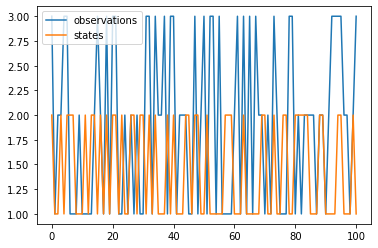

In [20]:
hmc_s = HiddenMarkovChain_Simulation(A, B, pi)
observation_hist, states_hist = hmc_s.run(100)  # length = 100
stats = pd.DataFrame({
    'observations': observation_hist,
    'states': states_hist}).applymap(lambda x: int(x[0])).plot()

In [21]:
hmc_s = HiddenMarkovChain_Simulation(A, B, pi)

stats = {}
for length in np.logspace(1, 5, 40).astype(int):
    observation_hist, states_hist = hmc_s.run(length)
    stats[length] = pd.DataFrame({
        'observations': observation_hist,
        'states': states_hist}).applymap(lambda x: int(x[0]))

S = np.array(list(map(lambda x: 
        x['states'].value_counts().to_numpy() / len(x), stats.values())))



NameError: name 'plt' is not defined

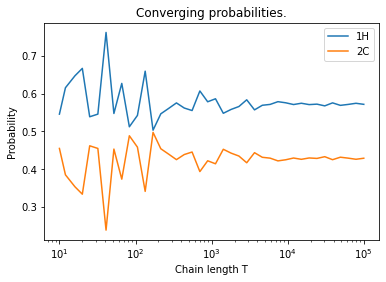

In [23]:
plt.semilogx(np.logspace(1, 5, 40).astype(int), S)
plt.xlabel('Chain length T')
plt.ylabel('Probability')
plt.title('Converging probabilities.')
plt.legend(['1H', '2C'])
plt.show()

In [24]:
class HiddenMarkovChain_Uncover(HiddenMarkovChain_Simulation):
    def _alphas(self, observations: list) -> np.ndarray:
        alphas = np.zeros((len(observations), len(self.states)))
        alphas[0, :] = self.pi.values * self.E[observations[0]].T
        for t in range(1, len(observations)):
            alphas[t, :] = (alphas[t - 1, :].reshape(1, -1) @ self.T.values) \
                         * self.E[observations[t]].T
        return alphas
    
    def _betas(self, observations: list) -> np.ndarray:
        betas = np.zeros((len(observations), len(self.states)))
        betas[-1, :] = 1
        for t in range(len(observations) - 2, -1, -1):
            betas[t, :] = (self.T.values @ (self.E[observations[t + 1]] \
                        * betas[t + 1, :].reshape(-1, 1))).reshape(1, -1)
        return betas
    
    def uncover(self, observations: list) -> list:
        alphas = self._alphas(observations)
        betas = self._betas(observations)
        maxargs = (alphas * betas).argmax(axis=1)
        return list(map(lambda x: self.states[x], maxargs))

In [27]:
class HiddenMarkovLayer(HiddenMarkovChain_Uncover):
    def _digammas(self, observations: list) -> np.ndarray:
        L, N = len(observations), len(self.states)
        digammas = np.zeros((L - 1, N, N))

        alphas = self._alphas(observations)
        betas = self._betas(observations)
        score = self.score(observations)
        for t in range(L - 1):
            P1 = (alphas[t, :].reshape(-1, 1) * self.T.values)
            P2 = self.E[observations[t + 1]].T * betas[t + 1].reshape(1, -1)
            digammas[t, :, :] = P1 * P2 / score
        return digammas

In [28]:
class HiddenMarkovModel:
    def __init__(self, hml: HiddenMarkovLayer):
        self.layer = hml
        self._score_init = 0
        self.score_history = []

    @classmethod
    def initialize(cls, states: list, observables: list):
        layer = HiddenMarkovLayer.initialize(states, observables)
        return cls(layer)

    def update(self, observations: list) -> float:
        alpha = self.layer._alphas(observations)
        beta = self.layer._betas(observations)
        digamma = self.layer._digammas(observations)
        score = alpha[-1].sum()
        gamma = alpha * beta / score 

        L = len(alpha)
        obs_idx = [self.layer.observables.index(x) \
                  for x in observations]
        capture = np.zeros((L, len(self.layer.states), len(self.layer.observables)))
        for t in range(L):
            capture[t, :, obs_idx[t]] = 1.0

        pi = gamma[0]
        T = digamma.sum(axis=0) / gamma[:-1].sum(axis=0).reshape(-1, 1)
        E = (capture * gamma[:, :, np.newaxis]).sum(axis=0) / gamma.sum(axis=0).reshape(-1, 1)

        self.layer.pi = ProbabilityVector.from_numpy(pi, self.layer.states)
        self.layer.T = ProbabilityMatrix.from_numpy(T, self.layer.states, self.layer.states)
        self.layer.E = ProbabilityMatrix.from_numpy(E, self.layer.states, self.layer.observables)
            
        return score

    def train(self, observations: list, epochs: int, tol=None):
        self._score_init = 0
        self.score_history = (epochs + 1) * [0]
        early_stopping = isinstance(tol, (int, float))

        for epoch in range(1, epochs + 1):
            score = self.update(observations)
            print("Training... epoch = {} out of {}, score = {}.".format(epoch, epochs, score))
            if early_stopping and abs(self._score_init - score) / score < tol:
                print("Early stopping.")
                break
            self._score_init = score
            self.score_history[epoch] = score

In [29]:
np.random.seed(42)

observations = ['3L', '2M', '1S', '3L', '3L', '3L']

states = ['1H', '2C']
observables = ['1S', '2M', '3L']

hml = HiddenMarkovLayer.initialize(states, observables)
hmm = HiddenMarkovModel(hml)

hmm.train(observations, 25)

Training... epoch = 1 out of 25, score = 0.0013006714785001687.
Training... epoch = 2 out of 25, score = 0.005509420540117939.
Training... epoch = 3 out of 25, score = 0.0055308588828216765.
Training... epoch = 4 out of 25, score = 0.005567116674468164.
Training... epoch = 5 out of 25, score = 0.005630618250468596.
Training... epoch = 6 out of 25, score = 0.005741158382934694.
Training... epoch = 7 out of 25, score = 0.0059280441106285.
Training... epoch = 8 out of 25, score = 0.006225866084209211.
Training... epoch = 9 out of 25, score = 0.006652847604517519.
Training... epoch = 10 out of 25, score = 0.00717178787364083.
Training... epoch = 11 out of 25, score = 0.007683641981602112.
Training... epoch = 12 out of 25, score = 0.00810084555475405.
Training... epoch = 13 out of 25, score = 0.008410987791562219.
Training... epoch = 14 out of 25, score = 0.00865079504603925.
Training... epoch = 15 out of 25, score = 0.008861021470118063.
Training... epoch = 16 out of 25, score = 0.00907509

In [33]:
np.random.seed(42)
observations = ['T', 'C', 'A', 'G', 'A', 'T', 'T']
states = ['0', '1', '2', '3']
observables = ['A', 'C', 'T', 'G']
hml = HiddenMarkovLayer.initialize(states, observables)
hmm = HiddenMarkovModel(hml)

hmm.train(observations, 25)

Training... epoch = 1 out of 25, score = 6.209615725585716e-05.
Training... epoch = 2 out of 25, score = 0.00013120286526508085.
Training... epoch = 3 out of 25, score = 0.00013143517714438068.
Training... epoch = 4 out of 25, score = 0.000131818206975203.
Training... epoch = 5 out of 25, score = 0.0001326146388989056.
Training... epoch = 6 out of 25, score = 0.0001343171815352374.
Training... epoch = 7 out of 25, score = 0.00013792791698194842.
Training... epoch = 8 out of 25, score = 0.00014543108748804376.
Training... epoch = 9 out of 25, score = 0.0001605426399709157.
Training... epoch = 10 out of 25, score = 0.0001899316066999166.
Training... epoch = 11 out of 25, score = 0.00024635615070273424.
Training... epoch = 12 out of 25, score = 0.0003596820958630358.
Training... epoch = 13 out of 25, score = 0.000599224083366628.
Training... epoch = 14 out of 25, score = 0.0010533374049748502.
Training... epoch = 15 out of 25, score = 0.0018016810951357516.
Training... epoch = 16 out of 2

KeyboardInterrupt: 